02で前処理をしたデータの読み込みとモデルの学習を行うためのnotebookです。  
ここで作成したモデルは **src/models/** フォルダに格納して推論の際に使うようにして下さい。

## 必要なライブラリのimport

In [80]:
import warnings
import time
import pickle

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)

In [81]:
# データの読み込み
train = pd.read_csv('../data/processed/processed20240619_train.csv')
test = pd.read_csv('../data/processed/processed20240619_test.csv')

In [82]:
train.head(100).to_csv('../data/processed/processed20240620_train.csv',index=None)
test.head(10).to_csv('../data/processed/processed20240620_test.csv',index=None)

In [83]:
# targetの正規化
scaler = MinMaxScaler()
train['target'] = scaler.fit_transform(train[['target']])

In [84]:
# # 目的変数と説明変数の作成
# target = train['target']
# del train['target']

In [95]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             confusion_matrix, roc_auc_score, roc_curve)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

# 特徴量と目的変数の分離
X = train.drop(columns=['target', 'card_id', 'first_active_month'])
y = train['target']

# 目的変数の正規化
scaler_y = MinMaxScaler()
y_normalized = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# IQR（四分位範囲）を使用して外れ値の閾値を決定
Q1 = np.percentile(y_normalized, 25)
Q3 = np.percentile(y_normalized, 75)
IQR = Q3 - Q1

# 下の外れ値の閾値を設定（IQRの1.5倍より小さい値を外れ値とする）
lower_bound = Q1 - 1.5 * IQR

# 下の外れ値を二値化
y_binary = (y_normalized < lower_bound).astype(int)

# データの標準化
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_binary, test_size=0.2, random_state=42)

# ハイパーパラメータチューニングのためのパラメータ設定
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# XGBoostのモデルを定義
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# クロスバリデーションの設定
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)


Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\Users\kento.nishino.ek\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.21198	validation_1-logloss:0.21084
[1]	validation_0-logloss:0.19951	validation_1-logloss:0.19840
[2]	validation_0-logloss:0.18981	validation_1-logloss:0.18873
[3]	validation_0-logloss:0.18226	validation_1-logloss:0.18127
[4]	validation_0-logloss:0.17646	validation_1-logloss:0.17556
[5]	validation_0-logloss:0.17188	validation_1-logloss:0.17102
[6]	validation_0-logloss:0.16827	validation_1-logloss:0.16763
[7]	validation_0-logloss:0.16537	validation_1-logloss:0.16498
[8]	validation_0-logloss:0.16311	validation_1-logloss:0.16300
[9]	validation_0-logloss:0.16107	validation_1-logloss:0.16130
[10]	validation_0-logloss:0.15959	validation_1-logloss:0.16004
[11]	validation_0-logloss:0.15830	validation_1-logloss:0.15911
[12]	validation_0-logloss:0.15704	validation_1-logloss:0.15819
[13]	validation_0-logloss:0.15599	validation_1-logloss:0.15741
[14]	validation_0-logloss:0.15521	validation_1-logloss:0.15698
[15]	validation_0-logloss:0.15452	validation_1-logloss:0.15653
[1

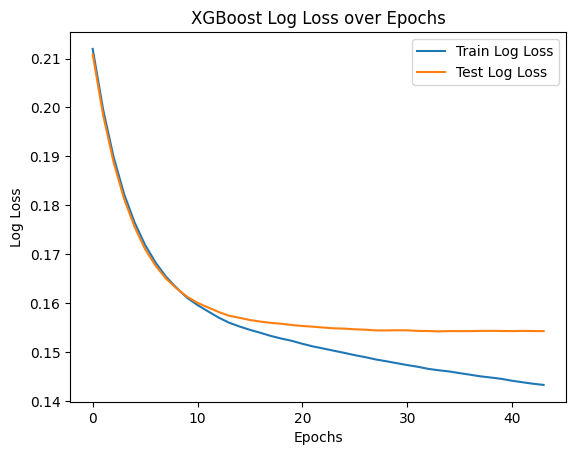

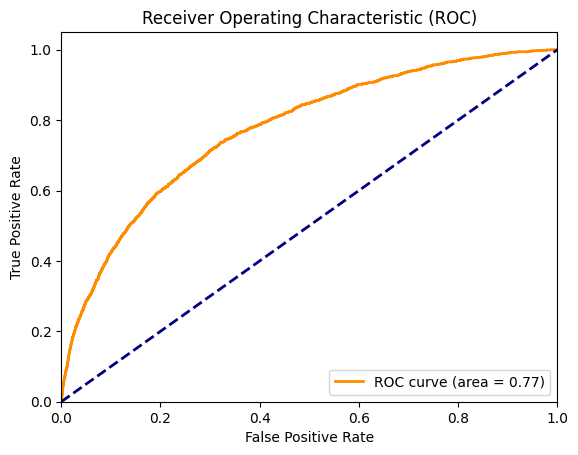

In [96]:

# GridSearchCVによるハイパーパラメータチューニング
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='f1', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# 最適なモデルを取得
best_model = grid_search.best_estimator_

# 学習の進捗状況を追跡するための評価結果を取得
eval_set = [(X_train, y_train), (X_test, y_test)]
best_model.fit(X_train, y_train, eval_set=eval_set, verbose=True, early_stopping_rounds=10)

# テストデータで予測
y_pred_prob = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_prob > 0.5).astype(int)

# 混合行列
conf_matrix = confusion_matrix(y_test, y_pred)
# 評価指標
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# 評価指標を表示
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC AUC: {roc_auc}')

# 学習曲線のプロット
results = best_model.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)
plt.figure()
plt.plot(x_axis, results['validation_0']['logloss'], label='Train Log Loss')
plt.plot(x_axis, results['validation_1']['logloss'], label='Test Log Loss')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss over Epochs')
plt.legend(loc='upper right')
plt.show()

# ROC曲線のプロット
fpr_roc, tpr_roc, _ = roc_curve(y_test, y_pred_prob)

plt.figure()
plt.plot(fpr_roc, tpr_roc, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [86]:

# 特徴量と目的変数の分離
X = train.drop(columns=['target', 'card_id', 'first_active_month'])
y = train['target']

# 目的変数の正規化
scaler_y = MinMaxScaler()
y_normalized = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# IQR（四分位範囲）を使用して外れ値の閾値を決定
Q1 = np.percentile(y_normalized, 25)
Q3 = np.percentile(y_normalized, 75)
IQR = Q3 - Q1

# 下の外れ値の閾値を設定（IQRの1.5倍より小さい値を外れ値とする）
lower_bound = Q1 - 1.5 * IQR

# 下の外れ値を二値化
y_binary = (y_normalized < lower_bound).astype(int)

# データの標準化
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_binary, test_size=0.2, random_state=42)

# ハイパーパラメータチューニングのためのパラメータ設定
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# XGBoostのモデルを定義
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# クロスバリデーションの設定
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# GridSearchCVによるハイパーパラメータチューニング
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='f1', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# 最適なモデルを取得
best_model = grid_search.best_estimator_

# 学習の進捗状況を追跡するための評価結果を取得
eval_result = {}
best_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='logloss', verbose=True, early_stopping_rounds=10, evals_result=eval_result)

# テストデータで予測
y_pred_prob = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_prob > 0.5).astype(int)

# 混合行列
conf_matrix = confusion_matrix(y_test, y_pred)
# 評価指標
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# 評価指標を表示
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC AUC: {roc_auc}')

# 学習曲線のプロット
epochs = len(eval_result['validation_0']['logloss'])
x_axis = range(0, epochs)
plt.figure()
plt.plot(x_axis, eval_result['validation_0']['logloss'], label='Test Log Loss')
plt.plot(x_axis, eval_result['validation_1']['logloss'], label='Train Log Loss')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss over Epochs')
plt.legend(loc='upper right')
plt.show()

# ROC曲線のプロット
fpr_roc, tpr_roc, _ = roc_curve(y_test, y_pred_prob)

plt.figure()
plt.plot(fpr_roc, tpr_roc, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [87]:

# 目的変数の正規化
scaler_y = MinMaxScaler()
y_normalized = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# IQR（四分位範囲）を使用して外れ値の閾値を決定
Q1 = np.percentile(y_normalized, 25)
Q3 = np.percentile(y_normalized, 75)
IQR = Q3 - Q1

# 下の外れ値の閾値を設定（IQRの1.5倍より小さい値を外れ値とする）
lower_bound = Q1 - 1.5 * IQR

# 下の外れ値を二値化
y_binary = (y_normalized < lower_bound).astype(int)

# データの標準化
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_binary, test_size=0.2, random_state=42)

# ハイパーパラメータチューニングのためのパラメータ設定
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# XGBoostのモデルを定義
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# クロスバリデーションの設定
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# GridSearchCVによるハイパーパラメータチューニング
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='f1', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# 最適なモデルを取得
best_model = grid_search.best_estimator_

# 学習の進捗状況を追跡するための評価結果を取得
eval_result = {}
best_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='logloss', verbose=True, early_stopping_rounds=10, evals_result=eval_result)

# テストデータで予測
y_pred_prob = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_prob > 0.5).astype(int)

# 混合行列
conf_matrix = confusion_matrix(y_test, y_pred)
# 評価指標
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# 評価指標を表示
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC AUC: {roc_auc}')

# 学習曲線のプロット
epochs = len(eval_result['validation_0']['logloss'])
x_axis = range(0, epochs)
plt.figure()
plt.plot(x_axis, eval_result['validation_0']['logloss'], label='Test Log Loss')
plt.plot(x_axis, eval_result['validation_1']['logloss'], label='Train Log Loss')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss over Epochs')
plt.legend(loc='upper right')
plt.show()

# ROC曲線のプロット
fpr_roc, tpr_roc, _ = roc_curve(y_test, y_pred_prob)

plt.figure()
plt.plot(fpr_roc, tpr_roc, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [97]:

# IQR（四分位範囲）を使用して外れ値の閾値を決定
Q1 = np.percentile(y_normalized, 25)
Q3 = np.percentile(y_normalized, 75)
IQR = Q3 - Q1

# 下の外れ値の閾値を設定（IQRの1.5倍より小さい値を外れ値とする）
lower_bound = Q1 - 1.5 * IQR

# 下の外れ値を二値化
y_binary = (y_normalized < lower_bound).astype(int)

# データの標準化
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_binary, test_size=0.2, random_state=42)

# ハイパーパラメータチューニングのためのパラメータ設定
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# XGBoostのモデルを定義
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# クロスバリデーションの設定
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# GridSearchCVによるハイパーパラメータチューニング
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='f1', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# 最適なモデルを取得
best_model = grid_search.best_estimator_

# 学習の進捗状況を追跡するための評価結果を取得
eval_result = {}
best_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='logloss', verbose=True, early_stopping_rounds=10, evals_result=eval_result)

# テストデータで予測
y_pred_prob = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_prob > 0.5).astype(int)

# 混合行列
conf_matrix = confusion_matrix(y_test, y_pred)
# 評価指標
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# 評価指標を表示
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC AUC: {roc_auc}')

# 学習曲線のプロット
epochs = len(eval_result['validation_0']['logloss'])
x_axis = range(0, epochs)
plt.figure()
plt.plot(x_axis, eval_result['validation_0']['logloss'], label='Test Log Loss')
plt.plot(x_axis, eval_result['validation_1']['logloss'], label='Train Log Loss')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss over Epochs')
plt.legend(loc='upper right')
plt.show()

# ROC曲線のプロット
fpr_roc, tpr_roc, _ = roc_curve(y_test, y_pred_prob)

plt.figure()
plt.plot(fpr_roc, tpr_roc, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


Fitting 3 folds for each of 108 candidates, totalling 324 fits


TypeError: XGBClassifier.fit() got an unexpected keyword argument 'evals_result'

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Confusion Matrix:
[[37146   197]
 [ 2933   108]]
Accuracy: 0.9224940570522979
Precision: 0.3540983606557377
Recall: 0.03551463334429464
F1 Score: 0.06455469216975493
ROC AUC: 0.7601015860655167


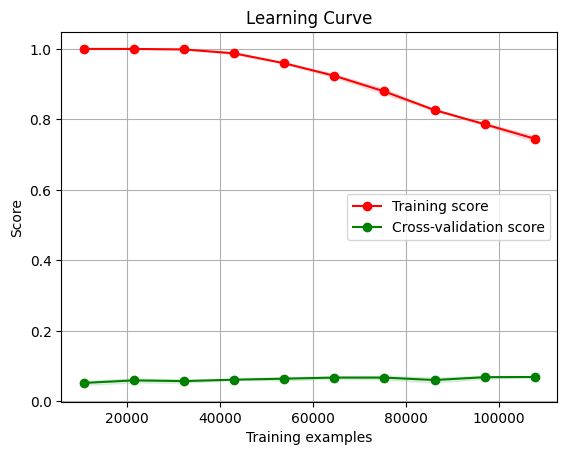

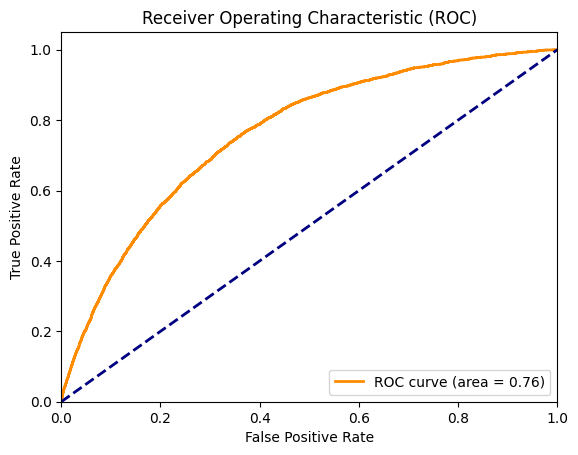

In [79]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, learning_curve
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, log_loss, roc_curve)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

# 特徴量と目的変数の分離
X = train.drop(columns=['target', 'card_id', 'first_active_month'])
y = train['target']

# 目的変数の正規化
scaler_y = MinMaxScaler()
y_normalized = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# IQR（四分位範囲）を使用して外れ値の閾値を決定
Q1 = np.percentile(y_normalized, 25)
Q3 = np.percentile(y_normalized, 75)
IQR = Q3 - Q1

# 外れ値の閾値を設定（IQRの1.5倍を上回る値を外れ値とする）
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 外れ値を二値化
y_binary = ((y_normalized < lower_bound) | (y_normalized > upper_bound)).astype(int)

# データの標準化
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_binary, test_size=0.2, random_state=42)

# ハイパーパラメータチューニングのためのパラメータ設定
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# XGBoostのモデルを定義
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# クロスバリデーションの設定
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# GridSearchCVによるハイパーパラメータチューニング
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='f1', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# 最適なモデルを取得
best_model = grid_search.best_estimator_

# テストデータで予測
y_pred_prob = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_prob > 0.5).astype(int)

# 混合行列
conf_matrix = confusion_matrix(y_test, y_pred)
# 評価指標
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# 評価指標を表示
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC AUC: {roc_auc}')

# 学習曲線をプロット
train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=cv, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring='f1')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title('Learning Curve')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.show()

# ROC曲線のプロット
fpr_roc, tpr_roc, _ = roc_curve(y_test, y_pred_prob)

plt.figure()
plt.plot(fpr_roc, tpr_roc, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [69]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             confusion_matrix, roc_auc_score, roc_curve, auc, log_loss, 
                             precision_recall_curve)
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 特徴量と目的変数の分離
X = train.drop(columns=['target', 'card_id', 'first_active_month'])
y = train['target']

# 目的変数の正規化
scaler_y = MinMaxScaler()
y_normalized = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# IQR（四分位範囲）を使用して外れ値の閾値を決定
Q1 = np.percentile(y_normalized, 25)
Q3 = np.percentile(y_normalized, 75)
IQR = Q3 - Q1

# 外れ値の閾値を設定（IQRの1.5倍を上回る値を外れ値とする）
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 外れ値を二値化
y_binary = ((y_normalized < lower_bound) | (y_normalized > upper_bound)).astype(int)

# データの標準化
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_binary, test_size=0.2, random_state=42)

# ハイパーパラメータチューニングのためのパラメータ設定
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# XGBoostのモデルを定義
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# クロスバリデーションの設定
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCVによるハイパーパラメータチューニング
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='f1', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# 最適なモデルを取得
best_model = grid_search.best_estimator_

# テストデータで予測
y_pred_prob = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_prob > 0.5).astype(int)

# 混合行列
conf_matrix = confusion_matrix(y_test, y_pred)
# 評価指標
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
fpr = conf_matrix[0, 1] / (conf_matrix[0, 0] + conf_matrix[0, 1])
logloss = log_loss(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)
precision_pr, recall_pr, _ = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall_pr, precision_pr)

# 評価指標を表示
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Specificity: {specificity}')
print(f'False Positive Rate (FPR): {fpr}')
print(f'Log Loss: {logloss}')
print(f'ROC AUC: {roc_auc}')
print(f'PR AUC: {pr_auc}')

# ROC曲線のプロット
fpr_roc, tpr_roc, _ = roc_curve(y_test, y_pred_prob)
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr_roc, tpr_roc, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# PR曲線のプロット
plt.figure()
plt.plot(recall_pr, precision_pr, color='blue', lw=2, label='PR curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

Fitting 5 folds for each of 108 candidates, totalling 540 fits


KeyboardInterrupt: 

In [61]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 特徴量と目的変数の分離
X = train.drop(columns=['target', 'card_id', 'first_active_month'])
y = train['target']

# 目的変数の正規化
scaler_y = MinMaxScaler()
y_normalized = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# IQR（四分位範囲）を使用して外れ値の閾値を決定
Q1 = np.percentile(y_normalized, 25)
Q3 = np.percentile(y_normalized, 75)
IQR = Q3 - Q1

# 外れ値の閾値を設定（IQRの1.5倍を上回る値を外れ値とする）
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 外れ値を二値化
y_binary = ((y_normalized < lower_bound) | (y_normalized > upper_bound)).astype(int)

# データの標準化
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_binary, test_size=0.2, random_state=42)

# XGBoostのモデルを定義
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# モデルの訓練
model.fit(X_train, y_train)

# テストデータで予測
y_pred_prob = model.predict_proba(X_test)[:, 1]

# 予測確率を基に外れ値フラグを付与（0.5を閾値とする）
threshold = 0.5
y_pred = (y_pred_prob > threshold).astype(int)

# 評価
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'F1 Score: {f1}')
print(f'Confusion Matrix:\n{conf_matrix}')

# 全データで予測
data_scaled = scaler_X.transform(X)
all_pred_prob = model.predict_proba(data_scaled)[:, 1]
train['outlier_flag'] = (all_pred_prob > threshold).astype(int)

# card_idごとの外れ値フラグを表示
outliers_by_card_id = train[['card_id', 'outlier_flag']]
print(outliers_by_card_id)

# 結果を保存する場合
# outliers_by_card_id.to_csv('/mnt/data/outliers_by_card_id.csv', index=False)


F1 Score: 0.05671191553544495
Confusion Matrix:
[[37163   180]
 [ 2947    94]]
                card_id  outlier_flag
0       C_ID_92a2005557             0
1       C_ID_3d0044924f             0
2       C_ID_d639edf6cd             0
3       C_ID_186d6a6901             0
4       C_ID_cdbd2c0db2             0
...                 ...           ...
201912  C_ID_963962de2c             0
201913  C_ID_1314773c0b             0
201914  C_ID_7666735b3d             0
201915  C_ID_73f5a0efd0             1
201916  C_ID_92c9984c58             0

[201917 rows x 2 columns]


In [34]:
# lightgbmのパラメータ
param = {'num_leaves': 111,
         'min_data_in_leaf': 149, 
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

In [35]:
# 特徴量の情報
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
categorical_feats = ['feature_2', 'feature_3']

In [36]:
# データをKFoldで5分割して学習
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(params=param,
                    train_set=trn_data,
                    num_boost_round=num_round,
                    valid_sets=[val_data],
                    callbacks=[lgb.early_stopping(stopping_rounds=200),
                               lgb.log_evaluation(100)])

    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    # モデルを保存
    with open(f'../src/models/model_fold_{fold_}.pkl', 'wb') as f:
        pickle.dump(clf, f)

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

NameError: name 'target' is not defined

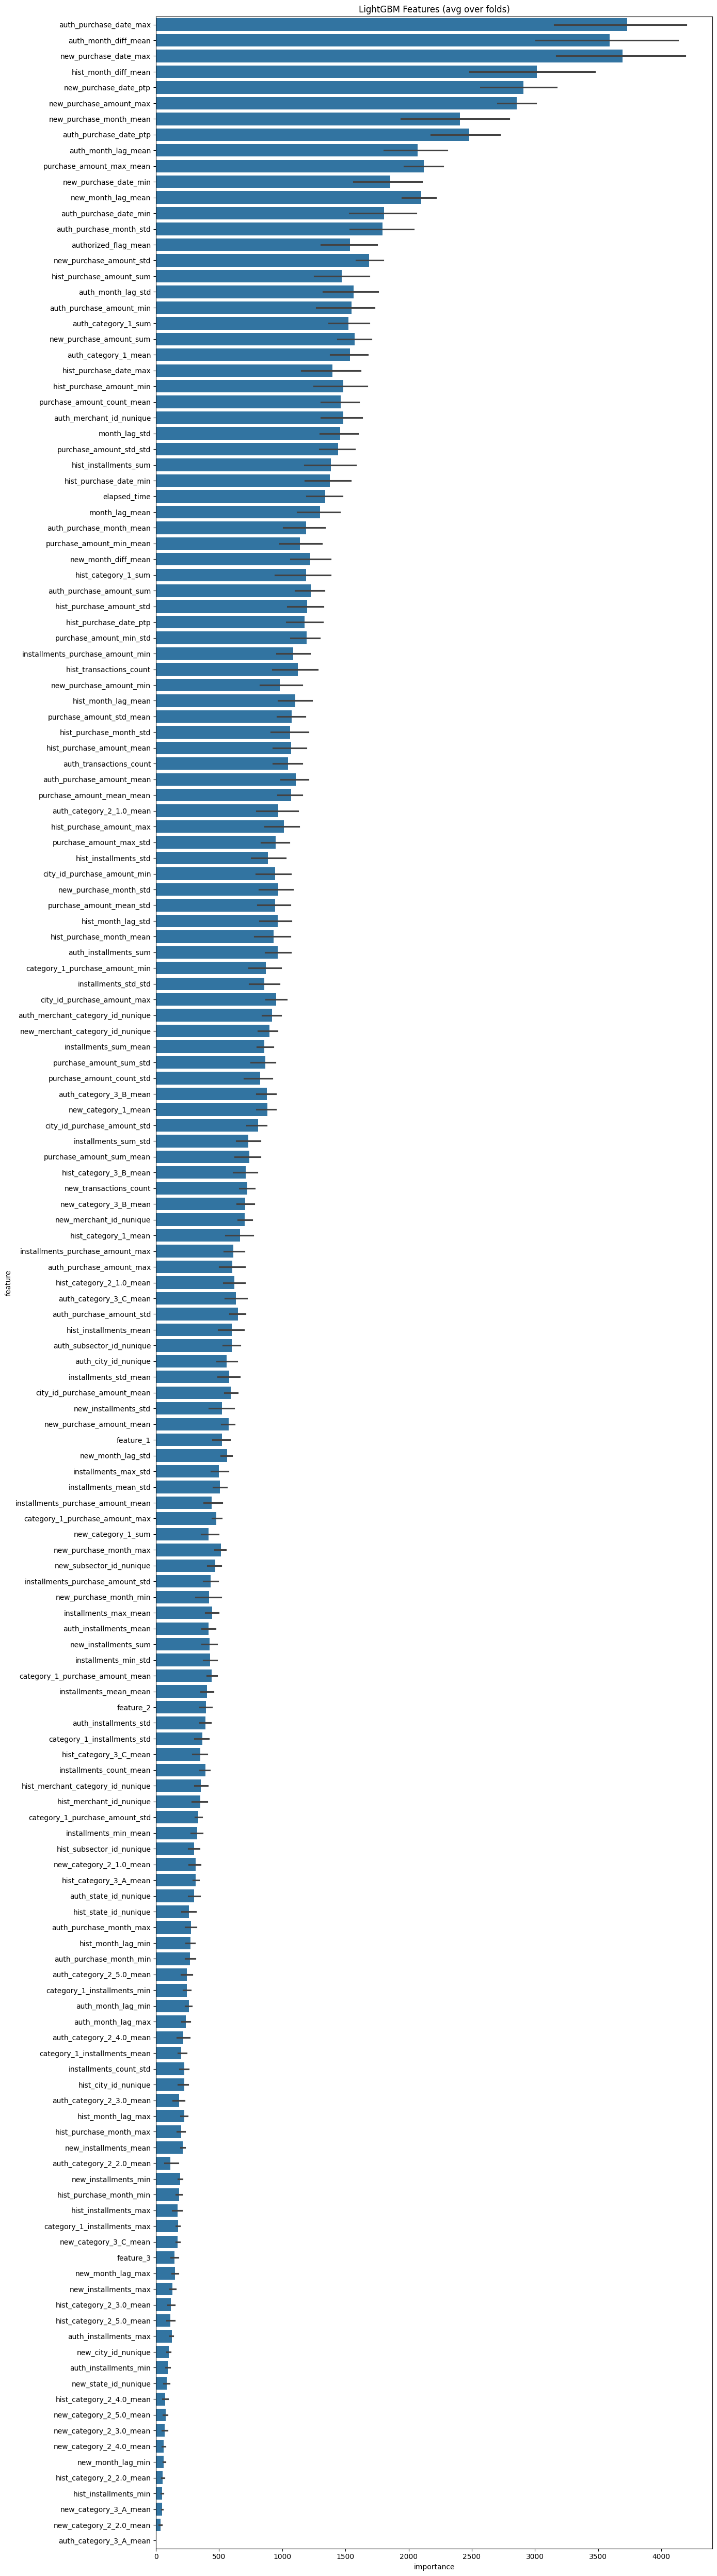

In [ ]:
# 特徴量重要度の可視化

cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
# plt.savefig('lgbm_importances.png')